# Deterministic Finite Automata (DFA)


## Introduction
In this notebook, we will see how to use `ggsolver` library to define and operate on DFAs. `ggsolver` is a python library being developed at CIRL that implements algorithms to synthesize winning strategies in two-player games on graphs. It consists  two packages:
* `ggsolver`: data structures and algorithms to represent and solve games on graph.
* `parsers`: different formal languages, their grammars and automata theoretic representations. 


**Installation:** Follow instructions on https://github.com/abhibp1993/cirl-assignments.


## Background

**Reading:** Chap. 1 and Section 2.1 from "Introduction to Automata Theory, Languages and Computation" book. 


**Recall:**
1. What is a state in finite automaton? What is a `dead` state? In our work, we generally refer to a dead state as a `sink` state.

2. What is an alphabet? What is a string? What is a language?

3. What is an incomplete automaton? How to complete an incomplete automaton?

4. What is a regular language? What other types of languages exist? 


**Graphs.**

We extensively use graphs to represent automata and game objects in `ggsolver`. In most cases, we will use `networkx.MultiDiGraph` to represent graphs. Basic familiarity with graph theory is assumed. 

*References*: 
* Tutorial: https://networkx.org/documentation/stable/tutorial.html
* API reference (`networkx.MultiDiGraph`):   https://networkx.org/documentation/stable/reference/classes/multidigraph.html#networkx.MultiDiGraph


##  General Philosophy in `ggsolver` 

Since `ggsolver` implements algorithms that operate on large automata and games on graphs (>10^5 nodes and edges), we need to keep memory and time complexity in mind while writing code. Thus, `ggsolver` defines two approaches or modes to define automata and games, namely `EXPLICIT` and `SYMBOLIC`. 

In `EXPLICIT` mode, an automaton is defined using its underlying graph. 
$$ \mathcal{A} = \langle G, q_0, F \rangle $$

In `SYMBOLIC` mode, an automaton is defined using the set of states and the transition function. 
$$ \mathcal{A} = \langle Q, \Sigma, \delta, q_0, F \rangle $$

Note that both modes can represent same automata However, `SYMBOLIC` mode is memory efficient and time inefficient since it does not store edges but instead generates them on-the-fly using transition function. Whereas, the `EXPLICIT` mode is time efficient but memory inefficient since it stores the edges explicitly, which can then be efficiently accessed. 


## Example. 

We first show how to define automaton in `EXPLICIT` and `SYMBOLIC` modes. Consider the automaton as shown below. 
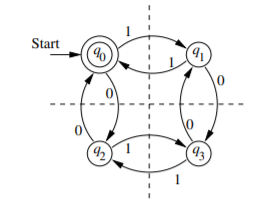

In [1]:
import sys
sys.path.extend(['/home/ggsolver', '/home/cirl-assignments'])

import parsers
import networkx as nx
import logging
logging.basicConfig(format="%(levelname)s:%(filename)s:%(lineno)d:%(message)s",
                   level=logging.INFO)

In [2]:
# EXPLICIT MODE

# 1. Create a networkx multi digraph that represents the underlying graph of DFA. 
graph = nx.MultiDiGraph()

# 2. Add nodes and edges to graph. 
#    Here, we can add nodes and edges one-by-one using `add_node, add_edge` methods. 
#    Or we can add them all at once using following methods. 
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([
    (0, 2, {"symbol": {0}}),
    (0, 1, {"symbol": {1}}),
    (1, 0, {"symbol": {0}}),
    (1, 3, {"symbol": {1}}),
    (2, 0, {"symbol": {1}}),
    (2, 3, {"symbol": {0}}),
    (3, 2, {"symbol": {0}}),
    (3, 1, {"symbol": {1}})
])

# 3. Instantiate a Dfa object
dfa_explicit = parsers.Dfa("dfa_explicit")

# 4. Construct Dfa explicitly.
dfa_explicit.construct_explicit(graph, init_st=0, final={0})

Once a `Dfa` object is constructed, we can access its methods and properties. Some commonly used methods, properties are 

* method: `delta(u, true_atoms)`: returns the state by following transition from state `u` enabled by `true_atoms`, which is the set of atoms in alphabet that are true. 
* method: `pred(v)`: returns a set of `(u, symbol)`-pairs such that state `v` can be reached from `u` given set of true atoms in `symbol`.  
* method: `Dfa.succ(u)`: returns a set of `(v, symbol)`-pairs such that state `v` can be reached from `u` given set of true atoms `symbol`. 
* method: `states()`: returns set of states of Dfa
* property: `alphabet`: returns the alphabet of Dfa
* property: `init_st`: returns initial state of Dfa
* property: `final`: returns final states of Dfa


In [3]:
print(f"dfa_explicit.delta(0, {0}) = {dfa_explicit.delta(0, {0})}")
print(f"dfa_explicit.pred(0) = {dfa_explicit.pred(0)}")
print(f"dfa_explicit.succ(0) = {dfa_explicit.succ(0)}")
print(f"dfa_explicit.alphabet = {dfa_explicit.alphabet}")
print(f"dfa_explicit.states() = {dfa_explicit.states()}")
print(f"dfa_explicit.init_st = {dfa_explicit.init_st}")
print(f"dfa_explicit.final = {dfa_explicit.final}")

dfa_explicit.delta(0, 0) = 2
dfa_explicit.pred(0) = {(1, frozenset({0})), (2, frozenset({1}))}
dfa_explicit.succ(0) = {(1, frozenset({1})), (2, frozenset({0}))}
dfa_explicit.alphabet = {0, 1}
dfa_explicit.states() = [0, 1, 2, 3]
dfa_explicit.init_st = 0
dfa_explicit.final = {0}


We can effeciently represent DFA's transition function by observing: 
* On input `0` at state `i`, next state is `(i+2) mod 4`.
* On input `1` at state `0 <= i < 2`, next state is `(i+1) mod 2`.
* On input `1` at state `2 <= i < 4`, next state is `2 + ((i+1) mod 2)`.

When transition function can be represented using such formulas, it is convenient to define DFA using `SYMBOLIC` mode.

In [4]:
# SYMBLIC MODE

# 1. Define states, alphabet, init_st and final
states = [0, 1, 2, 3]
alphabet = {0, 1}
init_st = 0
final = {0}

# 2. Define transition function
def delta(u, true_atoms):
    if set(true_atoms) == {0}:
        return (u+2) % 4
    elif 0 <= u < 2 and set(true_atoms) == {1}:
        return (u+1) % 2
    elif 2 <= u < 4 and set(true_atoms) == {1}:
        return 2 + ((u+1) % 2)
    else:
        return None

# 3. Instantiate Dfa object
dfa_symbolic = parsers.Dfa(name="dfa_symbolic")

# 4. Construct Dfa
dfa_symbolic.construct_symbolic(states, alphabet, delta, init_st, final)

Regardless of whether DFA is constructed explicitly or implicitly, all properties of `Dfa` can be accessed in the same way. 

In [5]:
print(f"dfa_symbolic.delta(0, {0}) = {dfa_symbolic.delta(0, {0})}")
print(f"dfa_symbolic.pred(0) = {dfa_symbolic.pred(0)}")
print(f"dfa_symbolic.succ(0) = {dfa_symbolic.succ(0)}")
print(f"dfa_symbolic.alphabet = {dfa_symbolic.alphabet}")
print(f"dfa_symbolic.states() = {dfa_symbolic.states()}")
print(f"dfa_symbolic.init_st = {dfa_symbolic.init_st}")
print(f"dfa_symbolic.final = {dfa_symbolic.final}")

dfa_symbolic.delta(0, 0) = 2
dfa_symbolic.pred(0) = {(1, frozenset({1})), (2, frozenset({0}))}
dfa_symbolic.succ(0) = {(1, frozenset({1})), (None, frozenset()), (2, frozenset({0})), (None, frozenset({0, 1}))}
dfa_symbolic.alphabet = {0, 1}
dfa_symbolic.states() = [0, 1, 2, 3]
dfa_symbolic.init_st = 0
dfa_symbolic.final = {0}


`Dfa` can be printed in summary or detail as follows. 

In [6]:
# Print object type and name
print(repr(dfa_symbolic))

# Pretty print details.
print(dfa_symbolic)

<Dfa "dfa_symbolic">

    This Dfa has 4 states.
    Alphabet: {0, 1}
    Starting state: 0
    Accepting states: {0}
    States: [0, 1, 2, 3]
    Transition function:
		0 -- {} --> None
		0 -- {0} --> 2
		0 -- {1} --> 1
		0 -- {0, 1} --> None
		1 -- {} --> None
		1 -- {0} --> 3
		1 -- {1} --> 0
		1 -- {0, 1} --> None
		2 -- {} --> None
		2 -- {0} --> 0
		2 -- {1} --> 3
		2 -- {0, 1} --> None
		3 -- {} --> None
		3 -- {0} --> 1
		3 -- {1} --> 2
		3 -- {0, 1} --> None


The automata tool generates warnings when `Dfa` is not complete. Recall a DFA is incomplete when the transition function `delta` returns a `None` for some input $\sigma \in \Sigma$ at some state $s \in S$. 

## Exercise 1 (The Protocol)

For this exercise, we will follow example from Sect. 2.1 in "Introduction to Automata Theory, Languages and Computation" book. 


### Part A (The DFAs). 

Define the customer, bank and store DFAs as shown in Figure 2.1 in the book. You may choose either of the modes as you like. 


In [14]:
dfa_customer = None
dfa_bank = None
dfa_store = None

### Part B (Complete the Incomplete DFA)

Given a DFA, implement the function to determine whether DFA is complete. If not, implement the `complete` function to generate complete DFA by extending the transition function. 

*Hint: For completing DFA, you may want to define a new DFA by extending `delta` function of input DFA.*

In [16]:
def is_complete(dfa):
    pass

def complete(dfa):
    pass

comp_dfa_customer = None
comp_dfa_bank = None
comp_dfa_store = None

### Part C (Product DFA)

Generate the product DFA as described in Sect. 2.1.4 of the book. 

In [17]:
def product(dfa1, dfa2):
    dfa = parsers.Dfa(name=f"{repr(dfa1)} x {repr(dfa2)}")
    
    # Implement.
    
    return dfa

prod_dfa_cust_bank = product(comp_dfa_customer, comp_dfa_bank)
prod_dfa = product(comp_dfa_store, prod_dfa_cust_bank)

### Part D (Validate Protocol)

Use the product DFA to answer the following questions:

1 What is the set of states unreachable from initial state?     
2 What is the set of BAD states, from which the final state is not reachable? 

There are a few ways to answer these questions. You may choose whichever way you like. 

A. In `EXPLICIT` mode, you may use property `graph` to get the underlying graph of product DFA. You may find `descendants` and `reverse` functions in `networkx` useful. 

B. If you implemented your DFAs or product operation in `SYMBOLIC` mode and you want to use approach described in (A), then you may call `make_explicit` function to convert DFA from `SYMBOLIC` to `EXPLICIT` mode. Then, follow (A). 

C. You may implement a `descendant` function using `succ` function to answer 1st question. Similarly, you may implement an `ancestor` function using `pred` function to answer 2nd question. 


In [18]:
# Your solution.

## Exercise 2 (Plotting)

It's easier to gain insight if we can visualize the `Dfa` graph. Use `networkx.draw` tool to plot the product `Dfa`. 


**Tips:**
* If you constructed product DFA in symbolic mode, then graph must be made explicit before plotting. This is done using `Dfa.make_explicit` function, which changes the `Dfa` mode to `EXPLICIT`. 

* Given an explicit DFA, `Dfa.graph` property will return the `networkx.MultiDiGraph` object which may be used for plotting. 


In [ ]:
def draw(dfa):
    pass